In [ ]:
import json
import random
from classes import *

with open("technologien.json", "r", encoding="utf-8") as f:
    technologien = json.load(f)
with open("namen.json", "r", encoding="utf-8") as f:
    namen = json.load(f)

def get_random_skills():
    skills = []
    for _ in range(1, random.randint(1, 5) + 1):
        tech_name = random.choice(technologien)
        skills.append(TechnologieWissen(tech_name, random.randint(0, 2 * 365)))
    return skills

## Formatieren der Daten

In [7]:
import json

data: list[MitarbeiterSkills] = []

for name in namen:
    skills = get_random_skills()
    mitarbeiter = MitarbeiterSkills(name, skills)
    data.append(mitarbeiter)

# Exportiere alle MitarbeiterSkills als JSON
with open("mitarbeiter_skills.json", "w", encoding="utf-8") as f:
    json.dump(
        [
            {
                "name": ma.name,
                "technologien": [
                    {"name": t.name, "letzte_verwendung": t.letzte_verwendung}
                    for t in ma.technologien
                ],
            }
            for ma in data
        ],
        f,
        ensure_ascii=False,
        indent=2,
    )

## Erstellen der Vektoren (Embeddings)

In [5]:
from openai import OpenAI

client = OpenAI()

def embedd(data):
    return client.embeddings.create(input=data, model="text-embedding-3-small").data[0].embedding

In [6]:
embedded_data = []

for ma in data:
    embedded_data.append(
        embedd(ma.to_embedding())
    )

## Erstellen der Vektordatenbank

In [57]:
import faiss
import numpy as np

dim = len(embedded_data[0])
index = faiss.IndexFlatL2(dim)

embeddings_np = np.array(embedded_data).astype("float32")
index.add(embeddings_np)

## Finden von Clustern mit KMeans

In [67]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(20, affinity='nearest_neighbors', n_init=100, assign_labels='discretize')
clusters = sc.fit_predict(embeddings_np)

## Suche in der Vektordatenbank

In [68]:
query = "Backend Technologien"
query_vector = client.embeddings.create(input=query, model="text-embedding-3-small").data[0].embedding

search_vector = np.array([query_vector]).astype('float32')

erg_anzahl = 5

D, indices = index.search(search_vector, erg_anzahl)

print(f"Distances: {D}")
print(f"Indices: {indices}")

for i in indices[0]:
    print(data[i])

Distances: [[1.3219886 1.3232605 1.3464255 1.3523738 1.3574529]]
Indices: [[ 99  15  39 127 218]]
Mitarbeiter:
  Name: Linda Voigt
  Skills:
    MySQL: vor 230 Tagen
    Confluence: vor 641 Tagen
    TensorFlow: vor 539 Tagen
    Jenkins: vor 84 Tagen
    Angular: vor 185 Tagen
Mitarbeiter:
  Name: Finn Neumann
  Skills:
    MySQL: vor 219 Tagen
Mitarbeiter:
  Name: Lena Richter
  Skills:
    Git: vor 635 Tagen
    JavaScript: vor 409 Tagen
Mitarbeiter:
  Name: Carla Pietsch
  Skills:
    React: vor 660 Tagen
    PHP: vor 137 Tagen
    Django: vor 304 Tagen
    Java: vor 565 Tagen
Mitarbeiter:
  Name: Dorothee Hermes
  Skills:
    Azure: vor 585 Tagen
    Confluence: vor 49 Tagen
    Tableau: vor 212 Tagen


## Darstellen mit t-SNE

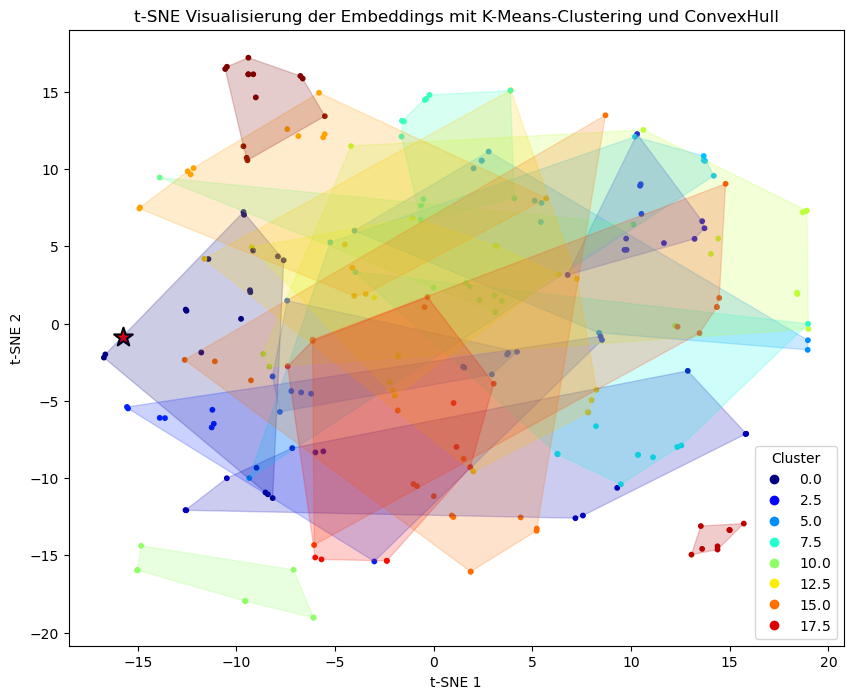

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# Kombiniere Embeddings und Query-Vektor für t-SNE
all_embeddings = np.vstack([embeddings_np, search_vector])
tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=300)
reduced_all = tsne.fit_transform(all_embeddings)
reduced_embeddings = reduced_all[:-1]
query_tsne = reduced_all[-1]

# Plotten der reduzierten Embeddings
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('jet')
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap=cmap, s=10)
plt.scatter(query_tsne[0], query_tsne[1], s=200, c="red", marker="*", edgecolor="black", linewidths=1.5, label="Query-Vektor")

# ConvexHull für jeden Cluster zeichnen, Farbe passend zu den Punkten
unique_clusters = np.unique(clusters)

for cluster_id in unique_clusters:
    points = reduced_embeddings[clusters == cluster_id]
    if len(points) >= 3:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        color = cmap(cluster_id / (len(unique_clusters)-1) if len(unique_clusters) > 1 else 0)
        plt.fill(hull_points[:, 0], hull_points[:, 1], alpha=0.2, color=color, edgecolor=color)

# Optional: Titel und Achsenbeschriftungen hinzufügen
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("t-SNE Visualisierung der Embeddings mit K-Means-Clustering und ConvexHull")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.show()

